<img src="img/TJI_logo_whitebg_440x220.jpg" alt="drawing" style="width: 220px;float: right"/>

# Analysis: Shootings and deaths by race and county population
---

## Overview

Generating two custom charts for the homepage, showing counts of shooting victims by race or county population, and counts per capita.

## Datasets used
* `tji/officer-involved-shooting/shot_civilians`
* `tji/officer-involved-shooting/shot_officers`
* `tji/auxiliary-datasests/census_data_by_county.csv`

##### Author: Everett Wetchler (everett.wetchler@gmail.com)
---

## [ Setup and load data ]

In [1]:
import datadotworld as dw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

%matplotlib inline

%load_ext watermark
%watermark -a 'Everett Wetchler' -d -t -z -w -p numpy,pandas,matplotlib,seaborn,datadotworld

Everett Wetchler 2018-05-31 19:51:07 PDT

numpy 1.14.3
pandas 0.20.1
matplotlib 2.2.0
seaborn 0.7.1
datadotworld 1.6.0
watermark 1.5.0


In [2]:
from lib.utils import *
from lib.style import *
plotsaver = PlotSaver('../plots/', 'ois_counts_by_', numbering=False)

Removing 3 past plots


In [3]:
datasets = dw.load_dataset('tji/officer-involved-shootings', force_update=True)
shot_civ = datasets.dataframes['shot_civilians']
shot_ofc = datasets.dataframes['shot_officers']

first_shooting = shot_civ.date_incident.min().strftime('%Y-%m-%d')
last_shooting = shot_civ.date_incident.max().strftime('%Y-%m-%d')
print("OIS data from %s to %s" % (first_shooting, last_shooting))

OIS data from 2015-09-02 to 2018-05-14


In [4]:
dataset = dw.load_dataset('tji/auxiliary-datasets', force_update=True)
census = dataset.dataframes['census_data_by_county']
county_populations = census[census['metric_description'] == 'Population estimates, July 1, 2016,  (V2016)'].iloc[0]
county_populations.drop([c for c in county_populations.index if c.startswith('metric')], inplace=True)
county_populations = dict((c.upper(), count) for c, count in county_populations.astype(int).items())

## Helper code

In [5]:
def adjust(df, order=None):
    df = df.copy()
    df.columns = ['injured', 'killed']
    for c in df.columns:
        df[c] = df[c]
    df['total'] = (df['injured'].fillna(0) + df['killed'].fillna(0))
    df['injured_frac'] = df['injured'].div(df['total'])
    df['killed_frac'] = df['killed'].div(df['total'])
    df.columns.name = None
    df.index.name = None
    if order:
        df = df.loc[order, :]
    return df.fillna(0)

def get_frames(category, cat_order=None, prefix=True):
    dfc = shot_civ.groupby([shot_civ[('civilian_' if prefix else '') + category], shot_civ.civilian_died]).size().unstack()
    dfc = adjust(dfc, cat_order)
    dfo = shot_ofc.groupby([shot_ofc[('officer_' if prefix else '') + category], shot_ofc.officer_died]).size().unstack()
    dfo = adjust(dfo, cat_order)
    return dfc, dfo

In [6]:
COLOR_INJURED = TJI_BLUE
COLOR_KILLED = TJI_RED
BAR_HEIGHT = 1
BARSPREAD = BAR_HEIGHT * 3
TITLE_SIZE = 40
LEGEND_SIZE = 24
CATEGORY_SIZE = 32
PERSON_SIZE = 24
CIV_ALPHA = 1.0

def make_chart(category, dfc, dfo, title_by):
    with sns.axes_style("white"):
        N_CATEGORIES = max(len(dfc), len(dfo))

        fig, ax = plt.subplots(1, frameon=False)
        fig.set_size_inches(20, N_CATEGORIES * 3)
        plt.subplots_adjust(left=0.35, right=.95)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(axis='x', alpha=0.7)
        ax.yaxis.set_visible(False)

        ax.set_xlim(0, max([dfc['total'].max(), dfo['total'].max()]))
        xrange = ax.get_xlim()[1] - ax.get_xlim()[0]
        ax.set_ylim(-BAR_HEIGHT, BARSPREAD * N_CATEGORIES + BAR_HEIGHT)
        yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
        xyratio = xrange / yrange

        bar_height_frac = BAR_HEIGHT / yrange
        x_count = -bar_height_frac * xrange * 0.6
        x_person = -bar_height_frac * xrange * 4.25
        x_category = -bar_height_frac * xrange * 5

        for df in [dfc, dfo]:
            offset = 0
            alpha = 1.0
            person = 'OFFICERS SHOT'
            if df is dfc:
                offset = BAR_HEIGHT * 1.05
                alpha = CIV_ALPHA
                person = 'CIVILIANS SHOT'
            for i, category in enumerate(reversed(df.index)):
                y = (i * BARSPREAD) + offset
                text_y = y + (BAR_HEIGHT / 2.0)
                labels = [None, None]
                if df is dfc and i == 0:
                    labels = ['Killed', 'Injured']
                # Stacked bars for injured and killed persons
                ax.barh(y, df.loc[category, 'killed'], HEIGHT=BAR_HEIGHT, color=COLOR_KILLED,
                        alpha=alpha, label=labels[0], align='edge')
                ax.barh(y, df.loc[category, 'injured'], HEIGHT=BAR_HEIGHT,color=COLOR_INJURED,
                        alpha=alpha, label=labels[1], align='edge', left=df.loc[category, 'killed'])
                # Label for 'CIVILIANS SHOT' (or 'OFFICERS SHOT')
                ax.text(x_person, text_y, person, horizontalalignment='left', verticalalignment='center',
                        fontsize=PERSON_SIZE)
                # Label for the number of persons shot
                ax.text(x_count, text_y, '(%d)' %  df.loc[category, 'total'], 
                        horizontalalignment='center', verticalalignment='center',
                        fontsize=PERSON_SIZE)
                if df is dfc:
                    # Text for category
                    ax.text(x_category, text_y - offset/2, category,
                            horizontalalignment='right', verticalalignment='center',
                            fontsize=CATEGORY_SIZE, fontweight='bold',
                            bbox=dict(facecolor=sns.color_palette()[i],
                                      edgecolor='black', linewidth=2,
                                      pad=20, alpha=0.5)
                           )

        ax.text(ax.get_xlim()[1] * 1/8, ax.get_ylim()[1],
                'Texas officer-involved shootings:\nPersons shot since Sept 2015',
                fontsize=TITLE_SIZE, fontweight='bold',
                horizontalalignment='center', verticalalignment='bottom')
        ax.legend(loc='center right', bbox_to_anchor=(1.0, 1.0), fontsize=LEGEND_SIZE,
                  ncol=1, borderpad=1, framealpha=1.0, facecolor=[.95]*3, frameon=True)
        return fig, ax

----
## OIS by race
----

Saving plot to ../plots/ois_counts_by_race.png


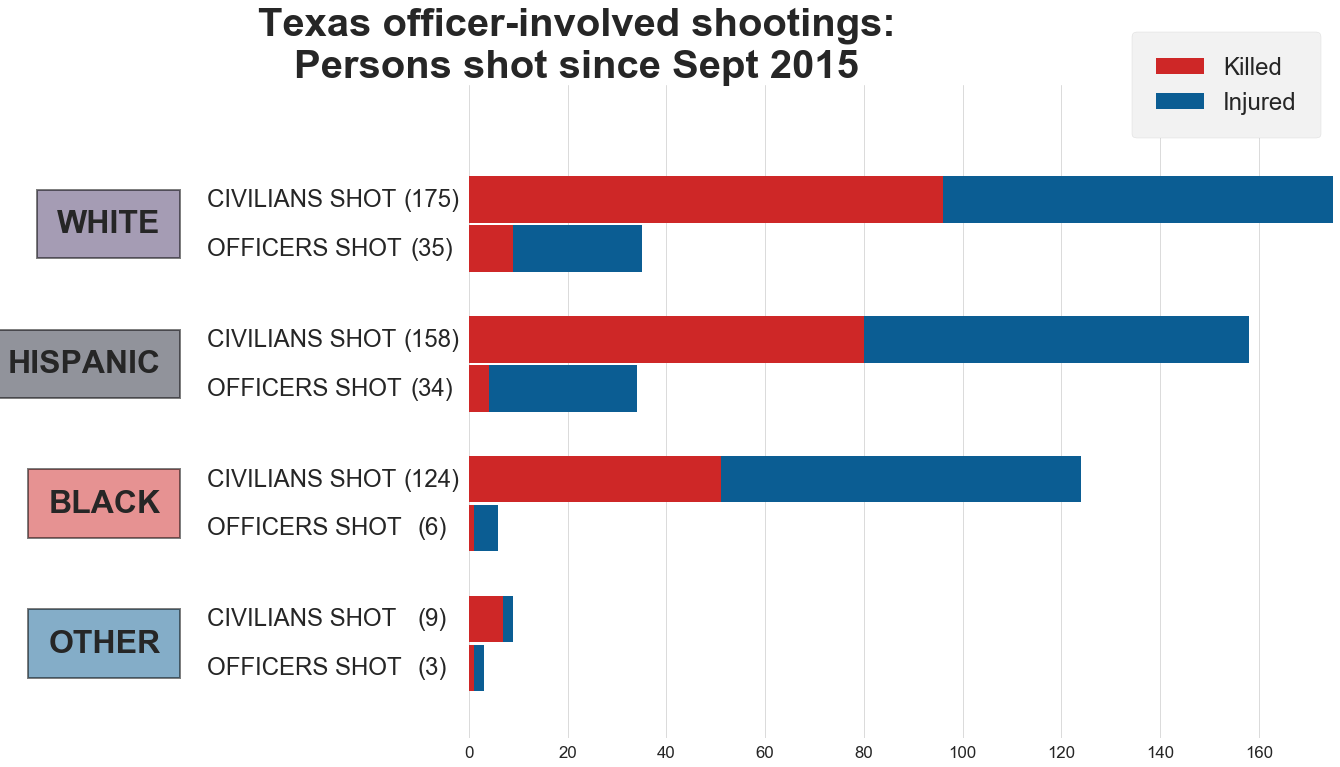

In [7]:
dfc, dfo = get_frames('race', ['WHITE', 'HISPANIC', 'BLACK', 'OTHER'])
fig, ax = make_chart('race', dfc, dfo, title_by='race')
plotsaver.saveplot(fig, 'race', dpi=300)

----
## OIS by county urbanization (population)
----

In [8]:
datasets = dw.load_dataset('tji/auxiliary-datasets', force_update=True)
census = datasets.dataframes['census_data_by_county']
census.set_index('metric_description', inplace=True)
census.drop([c for c in census.columns if c.startswith('metric_')], inplace=True, axis=1)
census.columns = [c.upper() for c in census.columns]
census = census.T
population = census['Population estimates, July 1, 2017,  (V2017)'].to_dict()

In [9]:
for df in (shot_civ, shot_ofc):
    df.drop([c for c in df.columns if c == 'incident_county_population'], axis=1, inplace=True)
    df['incident_county_population'] = df['incident_county'].apply(lambda c: population.get(c.replace(' ', '_'), np.nan))

In [10]:
print("Missing county population for %d shot civilians and %d shot officer" % (
    shot_civ.incident_county_population.isnull().sum(),
    shot_ofc.incident_county_population.isnull().sum()))

Missing county population for 2 shot civilians and 0 shot officer


In [11]:
POP_RURAL = 'RURAL AREAS\n(< 2,500 pop.)'
POP_UC = 'URBAN CLUSTERS\n(2,500 - 50,000 pop.)'
POP_UA = 'URBAN AREAS\n(50,000+ pop.)'
def pop_category(pop):
    if pop < 2500:
        return POP_RURAL
    elif pop < 50000:
        return POP_UC
    else:
        return POP_UA

for df in (shot_civ, shot_ofc):
    df['incident_county_population_category'] = df['incident_county_population'].apply(pop_category)

In [12]:
dfc, dfo = get_frames('incident_county_population_category', [pop_category(i) for i in (50001, 2501, 0)], prefix=False)

Saving plot to ../plots/ois_counts_by_urbanization.png


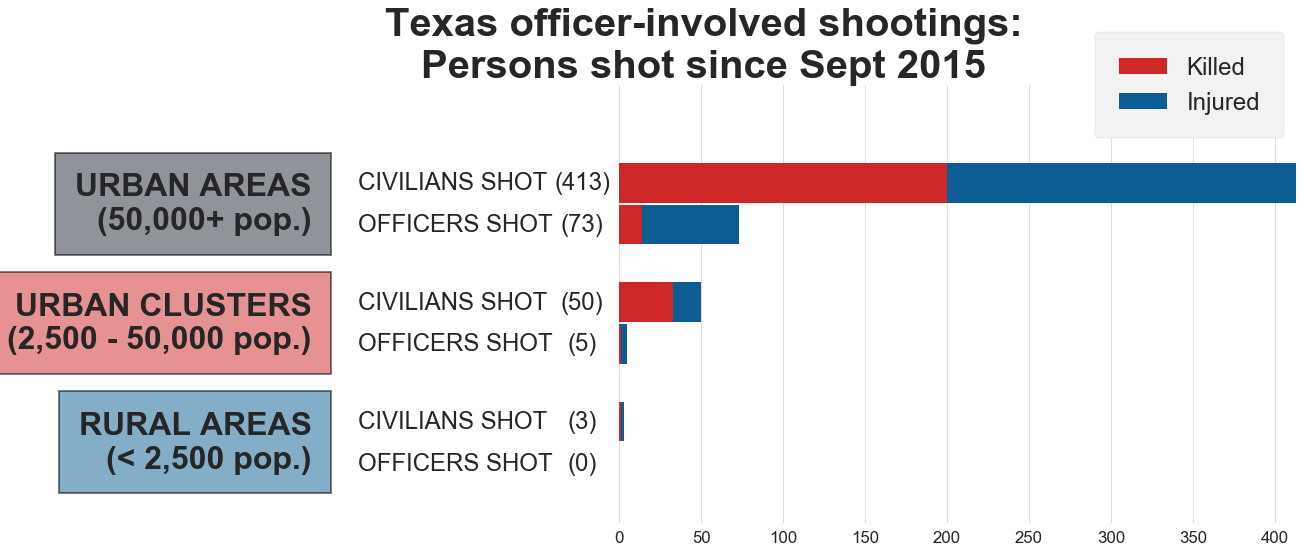

In [13]:
fig, ax = make_chart('incident_county_population_category', dfc, dfo, title_by='county urbanization')
fig.set_size_inches(fig.get_size_inches()[0], fig.get_size_inches()[1])
plt.subplots_adjust(left=0.48, top=0.8, right=0.95)
plotsaver.saveplot(fig, 'urbanization', dpi=300)

## Per capita

In [14]:
total_populations_by_category = {}
for name, pop in county_populations.items():
    if name == 'ALL_TEXAS':
        print(name, pop)
        continue
    cat = pop_category(pop)
    total_populations_by_category[cat] = total_populations_by_category.get(cat, 0) + pop

print('Sum of counties:', sum(total_populations_by_category.values()))

ALL_TEXAS 27862596
Sum of counties: 27862596


In [15]:
for i in dfc.index:
    dfc.loc[i, 'population'] = total_populations_by_category[i]

dfc['per_million'] = dfc['total'] * 1e6 / dfc['population']
dfc

,injured,killed,total,injured_frac,killed_frac,population,per_million
"URBAN AREAS\n(50,000+ pop.)",213,200,413,0.515738,0.484262,24939014.0,16.560398
"URBAN CLUSTERS\n(2,500 - 50,000 pop.)",17,33,50,0.340000,0.660000,2891858.0,17.289922
"RURAL AREAS\n(< 2,500 pop.)",2,1,3,0.666667,0.333333,31724.0,94.565629


Saving plot to ../plots/ois_counts_by_urbanization_per_million.png


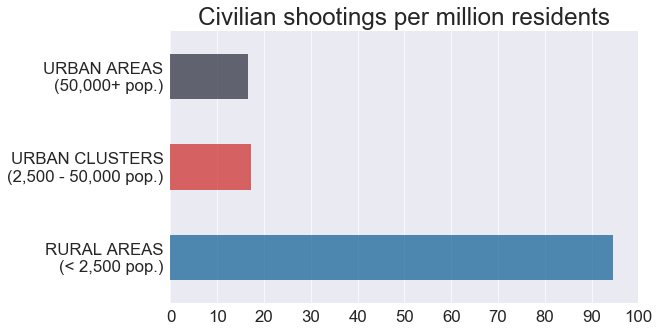

In [16]:
fig, ax = plt.subplots(1)
with sns.axes_style("white"):
    dfc['per_million'][::-1].plot(kind='barh', ax=ax, title='Civilian shootings per million residents',
                                 color=[TJI_BLUE, TJI_RED, TJI_DEEPBLUE], alpha=0.7)
    ax.set_xticks(np.arange(0, ax.get_xlim()[1] + 10, 10))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='x', alpha=0.7)

    fig.set_size_inches(10, 5)
    plt.subplots_adjust(left=0.25)
    plotsaver.saveplot(fig, 'urbanization_per_million', dpi=300)
pass

## Statistical testing

Use monte-carlo simulation to see if the rate of shootings in a given area are unusual.
* First, assume that shootings happen at the same rate everywhere (compute `p_shot`).
* Next, for ITER iterations, randomly "draw" a population of size N where N is the population of the area in question. For each, draw a uniform random variable and see if it is less than `p_shot` to count the number of people shot in this simulated iteration.
* Compute the fraction of iterations that show at least as many shootings as were actually observed in the area in question.

**Note:** I am not 100% sure this test is legitimate. Someone with stronger statistics, feel free to send me a PR or file a GitHub issue with your thoughts.

In [17]:
test = POP_RURAL
p_shot = dfc['total'].sum() / dfc['population'].sum()
n = int(dfc['population'].loc[test])
shot = dfc['total'].loc[test]
ITER = 100000
n, shot, p_shot

(31724, 3, 1.6724931158604173e-05)

In [18]:
results = []
for i in range(int(1e5)):
    if i % 1000 == 0:
        print(i, end=' ')
    results.append((np.random.rand(1, n) < p_shot).sum())

print('\np =', (np.array(results) >= shot).mean())

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 
p = 0.01693
